In [1]:
import os
import numpy as np
import ssl
import pandas as pd

import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import LSTM, Input, Dense, TimeDistributed, RepeatVector, SimpleRNN
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import Model

### Data load

In [2]:
url = 'https://raw.githubusercontent.com/JunetaeKim/DeepLearningClass/main/Dataset/Occupancy_Estimation.csv'
Occupancy = pd.read_csv(url)
Occupancy = Occupancy.drop(columns=['Date','Time'])
Occupancy['Room_Occupancy_Count'] = np.clip(Occupancy['Room_Occupancy_Count'], 0, 1)

#### Data description
https://archive.ics.uci.edu/ml/datasets/Room+Occupancy+Estimation

#### The experimental testbed for occupancy estimation was deployed in a 6m Ã— 4.6m room. The setup consisted of 7 sensor nodes and one edge node in a star configuration with the sensor nodes transmitting data to the edge every 30s using wireless transceivers. No HVAC systems were in use while the dataset was being collected.


##### Time: HH:MM:SS
##### Temperature: In degree Celsius
##### Light: In Lux
##### Sound: In Volts (amplifier output read by ADC)
##### CO2: In PPM
##### CO2 Slope: Slope of CO2 values taken in a sliding window
##### PIR: Binary value conveying motion detection
##### Room_Occupancy_Count: Ground Truth

### Data preprocessing 

In [3]:
### Normalization
scaler = MinMaxScaler()
scaler.fit(Occupancy)
Occupancy=scaler.transform(Occupancy)

Occupancy_T =  np.transpose(Occupancy, (1,0))
FrameDAta = tf.signal.frame(Occupancy_T, 41, 1)
FrameDAta = np.transpose(FrameDAta, (1,2,0))

### Data selection for input and output 
InpData = FrameDAta[:,:40, :16] # Input features for approximately the previous 20 minutes
TargetData = FrameDAta[:,40:, 16] # The target variable after approximately 2 minutes

In [4]:
InpData.shape, TargetData.shape

((10089, 40, 16), (10089, 1))

### Train/Test split

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split( InpData, TargetData, test_size=0.25, random_state=0)

### Model save directory setting

In [6]:
save_path = './Results/'
if not os.path.exists(save_path):
    os.mkdir(save_path)

### Model definition

In [7]:
def OccupModel ():
    InpL = Input(shape=(X_train.shape[1], X_train.shape[2]))
    LSTML = LSTM(20, return_sequences=True)(InpL)
    LSTMOut = LSTM(10, return_sequences=False)(LSTML)
    Output = Dense(1, activation='sigmoid')(LSTMOut)
    return Model(InpL,Output)   
    

In [8]:
### Model checkpoint
ModelSaveSameName = save_path+'Occup.hdf5'
ModelSave = ModelCheckpoint(filepath=ModelSaveSameName, monitor='val_loss', verbose=1, save_best_only=True)

### Model Early stop
EarlyStop = EarlyStopping(monitor='val_loss', patience=100)

OccupM = OccupModel()
OccupM.compile(loss=tf.losses.binary_crossentropy, optimizer='adam', metrics =['accuracy'])
OccupMHist = OccupM.fit(X_train, Y_train, validation_data=(X_test,Y_test), epochs=200, batch_size=100,  verbose=1, callbacks=[ModelSave, EarlyStop])

Epoch 1/200
76/76 [==============================] - 5s 34ms/step - loss: 0.4948 - accuracy: 0.8705 - val_loss: 0.1128 - val_accuracy: 0.9814

Epoch 00001: val_loss improved from inf to 0.11280, saving model to ./Results\Occup.hdf5
Epoch 2/200
76/76 [==============================] - 1s 11ms/step - loss: 0.1029 - accuracy: 0.9803 - val_loss: 0.0626 - val_accuracy: 0.9889

Epoch 00002: val_loss improved from 0.11280 to 0.06260, saving model to ./Results\Occup.hdf5
Epoch 3/200
76/76 [==============================] - 1s 10ms/step - loss: 0.0581 - accuracy: 0.9889 - val_loss: 0.0440 - val_accuracy: 0.9913

Epoch 00003: val_loss improved from 0.06260 to 0.04402, saving model to ./Results\Occup.hdf5
Epoch 4/200
76/76 [==============================] - 1s 10ms/step - loss: 0.0419 - accuracy: 0.9916 - val_loss: 0.0357 - val_accuracy: 0.9933

Epoch 00004: val_loss improved from 0.04402 to 0.03567, saving model to ./Results\Occup.hdf5
Epoch 5/200
76/76 [==============================] - 1s 10ms

### Model weight load and evaluate it

In [9]:
OccupM = OccupModel()
OccupM.compile(loss=tf.losses.binary_crossentropy, optimizer='adam', metrics =['accuracy'])
print('Before loading weights')
print(OccupM.evaluate(X_test,Y_test, batch_size=300 ))
print()

OccupM.load_weights(ModelSaveSameName)
print('After loading weights')
print(OccupM.evaluate(X_test,Y_test, batch_size=300))

Before loading weights
9/9 [==============================] - 1s 5ms/step - loss: 0.6816 - accuracy: 0.8225
[0.6819075345993042, 0.8192628026008606]

After loading weights
9/9 [==============================] - 0s 4ms/step - loss: 3.2303e-04 - accuracy: 1.0000
[0.00032303232001140714, 1.0]


### Plot loss graphs

Text(0, 0.5, 'loss')

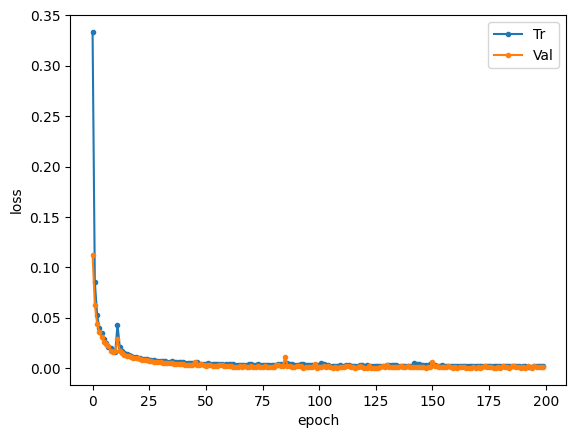

In [10]:
plt.plot(OccupMHist.history['loss'], label='Tr', marker='.')
plt.plot(OccupMHist.history['val_loss'], label='Val', marker='.')
plt.legend() 
plt.xlabel('epoch')
plt.ylabel('loss')

### Prediction example

In [11]:
Pred = OccupM.predict(X_test, batch_size=300 )
np.unique(np.round(Pred, 0), return_counts=True)

(array([0., 1.], dtype=float32), array([2067,  456], dtype=int64))